# 1. 기본 설정

In [1]:
# 라이브러리 로드
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt


In [57]:
# 이미지 로드
my_image_path = r'C:\Users\user\Desktop\AIFFEL\Day22\my_image.jpg'
bg_image_path = r'C:\Users\user\Desktop\AIFFEL\Day22\party.jpg'
cat_image_1_path = r'C:\Users\user\Desktop\AIFFEL\Day22\cat1.jpg'
cat_image_2_path = r'C:\Users\user\Desktop\AIFFEL\Day22\cat2.jpg'
cat_image_3_path = r'C:\Users\user\Desktop\AIFFEL\Day22\cat3.jpg'
cat_image_4_path = r'C:\Users\user\Desktop\AIFFEL\Day22\cat4.jpg'
cat_image_5_path = r'C:\Users\user\Desktop\AIFFEL\Day22\cat5.jpg'
cat_image_6_path = r'C:\Users\user\Desktop\AIFFEL\Day22\cat6.jpg'
sunglasses_path = r'C:\Users\user\Desktop\AIFFEL\Day22\sunglasses.png'
facelandmark_path = r"C:\Users\user\Desktop\AIFFEL\Day12\shape_predictor_68_face_landmarks.dat"

model_dir = r'C:\Users\user\Desktop\AIFFEL\Day22\models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

img_path = my_image_path
img_orig = cv2.imread(img_path)
RGB_img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
img_show = RGB_img_orig.copy()



In [100]:
# 레이블 부여 및 해당 색상코드 확인
LABEL_NAMES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']

colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype = int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

rgb_colormap = np.flip(colormap, axis =1)    # 초기 colormap은 bgr이어서 작업에 용이하게 rgb 버전을 별도 정의.
label_seg_color = dict(zip(LABEL_NAMES,colormap))
rgb_label_seg_color = dict(zip(LABEL_NAMES,rgb_colormap))
print(label_seg_color)
print(f"고양이의 구분색(RGB순)은: {rgb_label_seg_color['cat']}")
print(f"사람의 구분색(RGB순)은: {rgb_label_seg_color['person']}")
cat_seg_color = rgb_label_seg_color['cat']
person_seg_color = rgb_label_seg_color['person']

{'background': array([0, 0, 0]), 'aeroplane': array([128,   0,   0]), 'bicycle': array([  0, 128,   0]), 'bird': array([128, 128,   0]), 'boat': array([  0,   0, 128]), 'bottle': array([128,   0, 128]), 'bus': array([  0, 128, 128]), 'car': array([128, 128, 128]), 'cat': array([64,  0,  0]), 'chair': array([192,   0,   0]), 'cow': array([ 64, 128,   0]), 'diningtable': array([192, 128,   0]), 'dog': array([ 64,   0, 128]), 'horse': array([192,   0, 128]), 'motorbike': array([ 64, 128, 128]), 'person': array([192, 128, 128]), 'pottedplant': array([ 0, 64,  0]), 'sheep': array([128,  64,   0]), 'sofa': array([  0, 192,   0]), 'train': array([128, 192,   0]), 'tv': array([  0,  64, 128])}
고양이의 구분색(RGB순)은: [ 0  0 64]
사람의 구분색(RGB순)은: [128 128 192]


In [101]:
# 사람 뿐 아니라 고양이 등 여러가지를 분리할 것이므로 분리기능을 함수로 일반화.
# 이미지 경로, 분리모델 파일, 분리대상의 구분색을 입력받아 객체, 배경, 마스크, 구분값을 출력한다.
def obj_segment(img_path, model_file, seg_color):                 
    
    img_orig = cv2.imread(img_path)
    #RGB_img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    
    # 분리작업
    from pixellib.semantic import semantic_segmentation
    model = semantic_segmentation()
    model.load_pascalvoc_model(model_file)
    segvalues, output = model.segmentAsPascalvoc(img_path)
    
    seg_map = np.all(output == seg_color, axis = -1)  #axis = -1 : 현재 배열의 마지막 축. -> 색깔축을 의미.
    
    # 이미지 마스크 설정
    img_mask = seg_map.astype(np.uint8)*255 # 마스크를 이진 이미지화.
    binary_mask = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2RGB)
    not_binary_mask = cv2.bitwise_not(binary_mask)
    
    # 사람만 있는 이미지 
    obj = cv2.bitwise_and(binary_mask, img_orig)
    rgb_obj = cv2.cvtColor(obj, cv2.COLOR_BGR2RGB)
    
    # 배경만 있는 이미지 
    bg = cv2.bitwise_and(not_binary_mask, img_orig)
    rgb_bg = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)
        
    return rgb_obj, rgb_bg, img_mask, segvalues

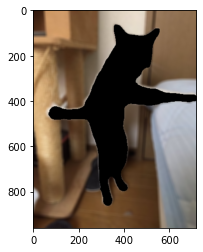

In [106]:
# 배경 블러링 함수 정의. 이미지 원본, 이미지 마스크, 블러 커널 크기를 받아 블러된 배경과 흑백 마스크를 출력한다.
def blur_bg(img_raw, img_mask, blur_kernerl_size):
    img_orig_blur = cv2.blur(img_raw, (blur_kernerl_size, blur_kernerl_size))
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    
    return img_bg_blur, img_mask_color

# 2. 인물사진 제작

## (1) 고양이 인물사진

In [102]:
cat_raw = cv2.imread(cat_image_6_path)

In [104]:
dancing_cat, bg_cat, cat_mask, segvalues_cat = obj_segment(cat_image_6_path, model_file, cat_seg_color)

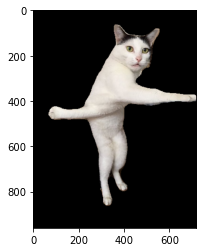

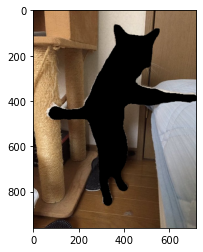

In [105]:
plt.imshow(dancing_cat)
plt.show()

plt.imshow(bg_cat)
plt.show()

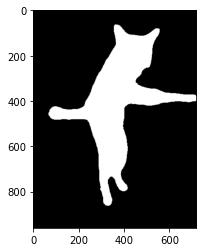

In [107]:
# 블러된 배경과 흑백 이미지 마스크 결과 확인
blur_bg_cat, cat_mask_color = blur_bg(cat_raw, cat_mask, 15)
plt.imshow(cv2.cvtColor(blur_bg_cat, cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(cat_mask_color, cv2.COLOR_BGR2RGB))
plt.show()

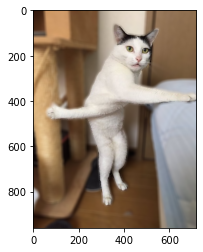

In [108]:
# 인물사진화 완료된 고양이 최종 결과 출력.
cat_img_concat = np.where(cat_mask_color == 255, cat_raw, blur_bg_cat)
plt.imshow(cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
def person_segment(img_path, model_file):
    
    img_orig = cv2.imread(img_path)
    RGB_img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    
    # 분리작업
    from pixellib.semantic import semantic_segmentation
    model = semantic_segmentation()
    model.load_pascalvoc_model(model_file)
    segvalues, output = model.segmentAsPascalvoc(img_path)
    
    seg_map = np.all(output == seg_color, axis = -1)  #axis = -1 : 현재 배열의 마지막 축. -> 색깔축을 의미.
    
    # 이미지 마스크 설정
    img_mask = seg_map.astype(np.uint8)*255 # 마스크를 이진 이미지화.
    binary_mask = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2RGB)
    not_binary_mask = cv2.bitwise_not(binary_mask)
    
    # 사람만 있는 이미지 
    person = cv2.bitwise_and(binary_mask, RGB_img_orig)
    
    # 배경만 있는 이미지 
    bg = cv2.bitwise_and(not_binary_mask, RGB_img_orig)
        
    return person, bg, segvalues

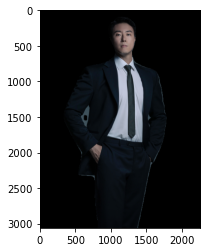

In [58]:
man, bg_man, segvalues_man = obj_segment(my_image_path, model_file, human_seg_color)
#for class_id in segvalues['class_ids']:
#    print(LABEL_NAMES[class_id])
man_show = man.copy()  # 후속 작업을 위한 백업본 생성.

plt.imshow(man)
plt.show()

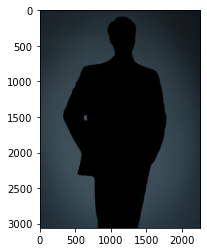

In [6]:
plt.imshow(bg_man)
plt.show()

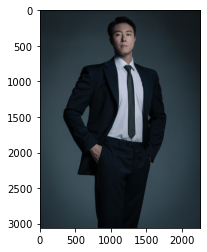

In [7]:
plt.imshow(img_show)
plt.show()

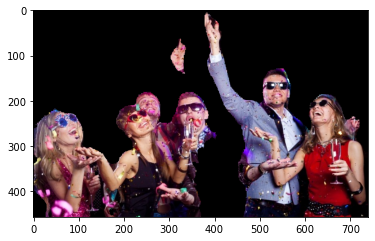

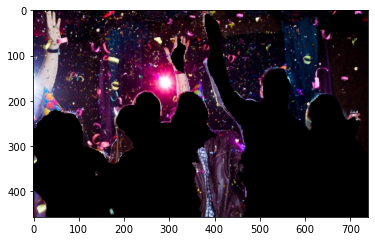

In [8]:
#img_path = bg_image_path
party_orig = cv2.imread(bg_image_path)
RGB_party_orig = cv2.cvtColor(party_orig, cv2.COLOR_BGR2RGB)
people_party, bg_party, segvalues_party = person_segment(bg_image_path, model_file)

plt.imshow(people_party)
plt.show()
plt.imshow(bg_party)
plt.show()

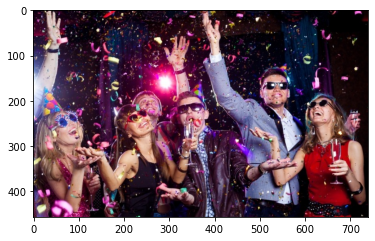

In [9]:
plt.imshow(RGB_party_orig)
plt.show()

In [10]:
RGB_party_orig.shape

(457, 740, 3)

In [11]:
man.shape

(3059, 2253, 3)

In [12]:
def sunglasses_landmark(raw_img, facelandmark_path):
    import dlib
    detector_hog = dlib.get_frontal_face_detector()
    rgb_raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
    dlib_rects = detector_hog(rgb_raw_img, 1) # (image, num of image pyramid)
    
    landmark_predictor = dlib.shape_predictor(facelandmark_path)
    list_landmarks = []
    
    # 얼굴 영역 박스마다 face landmark를 찾아냄.
    for dlib_rect in dlib_rects:
        points = landmark_predictor(rgb_raw_img, dlib_rect)
    
        # face landmark 좌표를 저장.
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
        
    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(raw_img, point, 2, (0, 255, 255), -1)
    
    #rgb_raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
    
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        print (landmark[27])   # 미간의 index는 27
        x = landmark[27][0] - dlib_rect.width()//2
        y = landmark[27][1] - dlib_rect.height()//3  # //: 나누고 소수점 이하 버림
        w = h = dlib_rect.width()
        print ('(x,y) : (%d, %d)'%(x,y))
        print ('(w,h) : (%d, %d)'%(w,h))
    
    return x, y, w, h

In [13]:
x, y, w, h = sunglasses_landmark(man, facelandmark_path)


(1174, 341)
(x,y) : (981, 213)
(w,h) : (386, 386)


(386, 386, 3)


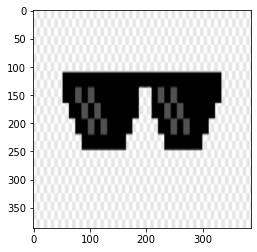

In [14]:
img_sticker = cv2.imread(sunglasses_path)
img_sticker = cv2.resize(img_sticker, (w,h))
img_sticker = img_sticker    # 합성시 검은 배경(0)과의 차이를 두기 위해 1을 더함.
print(img_sticker.shape)
plt.imshow(img_sticker)
plt.show()

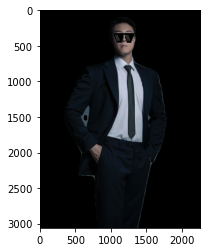

In [15]:


sticker_area = man_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
man_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker < 200, img_sticker, sticker_area).astype(np.uint8)  # 선글라스의 회색을 살리기 위해 조건을 조금 변경했다.
print('파티에 가기 위해 선글라스를 착용하였다.')
plt.imshow(man_show)
plt.show()

In [44]:
print(f'파티장의 크기는 가로: {show_bg_party.shape[1]}, 세로: {show_bg_party.shape[0]}이다.')


파티장의 크기는 가로: 740, 세로: 457이다.


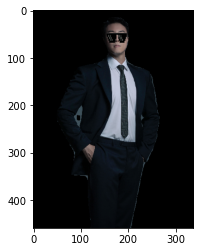

In [16]:
resize_man_show = cv2.resize(man_show, (0,0), fx = 0.15, fy = 0.15) # 15% 크기로 리사이즈.
print('거인이 되지 않게 파티장 크기에 맞게 몸 크기를 줄였다.')
plt.imshow(resize_man_show)
plt.show()

In [21]:
resize_man_show.shape

(459, 338, 3)

In [17]:
#cv2.imwrite('man_sunglasses.jpg',man_show)

In [18]:
cv2.imwrite('man.jpg',man)

True

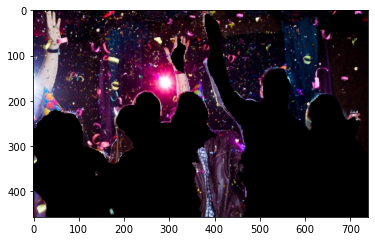

In [19]:
show_bg_party = bg_party.copy()
plt.imshow(show_bg_party)
plt.show()

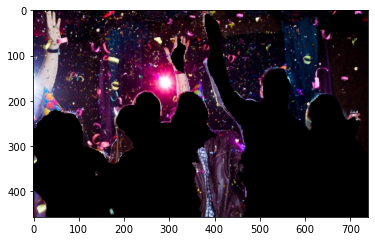

In [20]:
resize_man_show = resize_man_show
plt.imshow(show_bg_party)
plt.show()

In [22]:
show_bg_party.shape

(457, 740, 3)

In [23]:
start_point = (200, 0)   #(세로, 가로) 시작점.
print(start_point[0])
print(start_point[1])

200
0


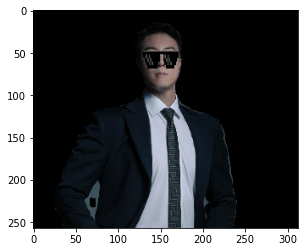

In [32]:
cut_resize_man_show = resize_man_show[:(show_bg_party.shape[0]-start_point[0]), 25:]
plt.imshow(cut_resize_man_show)
plt.show()

In [33]:
cut_resize_man_show.shape

(257, 313, 3)

In [34]:
#sticker_area_bg_party.shape

In [35]:
show_bg_party[start_point[0]:show_bg_party.shape[0], start_point[1]:start_point[1]-25+resize_man_show.shape[1]].shape

(257, 313, 3)

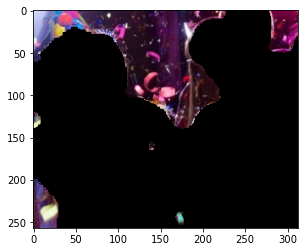

In [36]:
show_bg_party = bg_party.copy()
sticker_area_bg_party = show_bg_party[start_point[0]:show_bg_party.shape[0], start_point[1]:start_point[1]-25+resize_man_show.shape[1]]
plt.imshow(sticker_area_bg_party)
plt.show()

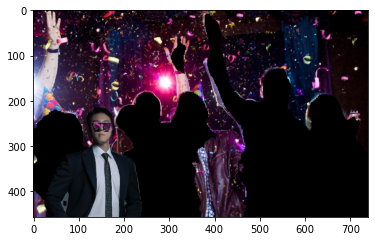

In [37]:
#show_bg_party = bg_party.copy()
show_bg_party[start_point[0]:show_bg_party.shape[0], start_point[1]:start_point[1]-25+resize_man_show.shape[1]] =\
np.where(cut_resize_man_show>0, cut_resize_man_show, sticker_area_bg_party).astype(np.uint8)
plt.imshow(show_bg_party)
plt.show()

In [38]:
copy_show_bg_party = show_bg_party.copy()

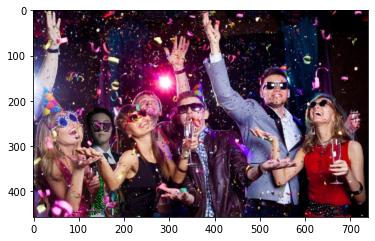

In [39]:
show_bg_party = np.where(people_party>0, people_party, show_bg_party)
plt.imshow(show_bg_party)
plt.show()

### 중간 회고
- 인싸가 되기 위해 선글라스를 썼다.
- 키를 맞추기 위해 다리를 자르는 아픔을 감수하였다.
- 사람들이 다른 장소로 떠난 사이 자연스럽게 잠입하였다.
- 사람들이 돌아와서 아까부터 거기 있었던 것처럼 되었다.
- 내 사진에서 완전히 검은 지점(color value = 0)은 커버가 되지 않았다. 마스크를 활용해서 인물 영역과 겹치는 부분을 제외하는 작업이 추가로 필요할 듯.